# 앙상블 모형 기반 신용카드 일별 매출 예측
This is a replication project of credit card sales prediction. 
How to make better
 - Add more about Key Questions
 - What I focused on this project

In [ ]:
# %% 0. Environment Settings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('ggplot')

plt.rc('font', family='Malgun Gothic')
# plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

numpy version: 1.19.2
pandas version: 1.1.5
seaborn version: 0.11.2
matplotlib version: 3.3.4


## 1. Data Loading

In [9]:
# %% 1. LOAD THE DATA
# Data Source: KDX Data - [NH농협카드] 일자별 소비현황_서울
bas_ym = pd.date_range(start='20200101', end='20240630', freq='MS').strftime('%Y%m').tolist()

df = pd.DataFrame()

for i, var in enumerate(bas_ym):
    data_path = f'data/[NH농협카드] 일자별 소비현황_서울_{var}.csv'
    
    encodings = ['utf-8-sig', 'euc-kr', 'cp949']
    for encoding in encodings:
        try:
            tmp_df = pd.read_csv(data_path, encoding=encoding)
            break
        except UnicodeDecodeError:
            continue
    else:
        raise ValueError(f"Failed to read {data_path} with available encodings.")
    
    df = pd.concat([df, tmp_df], axis=0)
    
print(df.shape)
print(df.head())

(1643, 8)
   시도      승인일자  이용건수_전체  이용금액_전체  이용건수_개인  이용금액_개인  이용건수_법인  이용금액_법인
0  서울  20200101   1827.0  48116.0   1770.0  45654.0     57.0   2462.0
1  서울  20200102   2071.0  78042.0   1932.0  66654.0    139.0  11388.0
2  서울  20200103   2140.0  77224.0   1995.0  64302.0    144.0  12922.0
3  서울  20200104   1969.0  55070.0   1891.0  51702.0     78.0   3369.0
4  서울  20200105   1711.0  46359.0   1649.0  43796.0     62.0   2563.0


## 2. DATA PREPROCESSING

In [10]:
# Type Conversion (int64 -> datetime64)
df['date'] = pd.to_datetime(df['승인일자'], format='%Y%m%d')

# Decimal Point Handling
df['이용금액_전체_억원'] = df['이용금액_전체'] / 100
df['이용금액_개인_억원'] = df['이용금액_개인'] / 100
df['이용금액_법인_억원'] = df['이용금액_법인'] / 100

# Derived Variables
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek

# Nominal to Ordinal Variable
df['dayname'] = pd.Categorical(df['date'].dt.day_name(), 
                               categories=['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday'],
                               ordered=True)

# Add weekend variable
df['weekend'] = df['dayname'].isin(['Saturday', 'Sunday'])

# Nullity Check
print(df.isna().sum())

# Train-Test Split
df_train = df[df['year'] != 2024]
df_test = df[df['year'] == 2024]

print(df_train.shape, df_test.shape)

# Reset Index
df.reset_index(drop=True, inplace=True)

시도            0
승인일자          0
이용건수_전체       0
이용금액_전체       0
이용건수_개인       0
이용금액_개인       0
이용건수_법인       0
이용금액_법인       0
date          0
이용금액_전체_억원    0
이용금액_개인_억원    0
이용금액_법인_억원    0
year          0
month         0
day           0
dayofweek     0
dayname       0
weekend       0
dtype: int64
(1461, 18) (182, 18)


## 3. EDA WITH VISUALIZATION

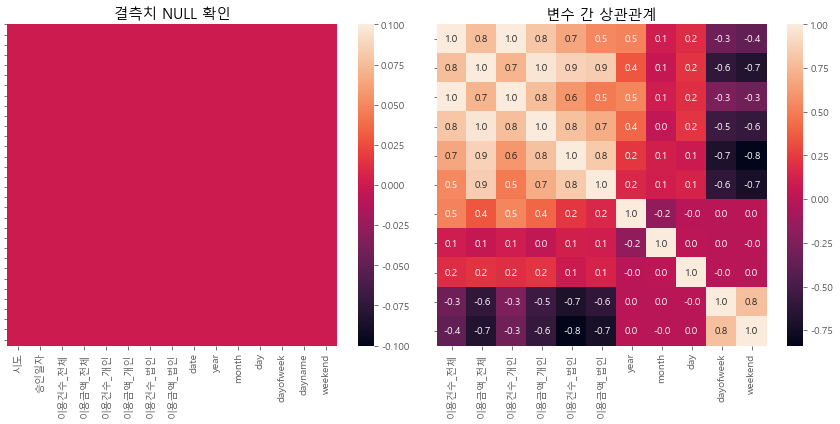

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# 3-1. Null Handling
sns.heatmap(df.isna(), ax=axes[0])
axes[0].set_title('결측치 NULL 확인')
axes[0].set_yticklabels([])

# 3-2. Correlation Matrix (Multicolinearity Check)
corr_mat = df.drop(['시도', '승인일자', 'dayname'], axis=1).corr()

sns.heatmap(corr_mat, annot=True, fmt='.1f', ax=axes[1])
axes[1].set_yticklabels([])

axes[1].set_title('변수 간 상관관계')
plt.tight_layout()
plt.show() 

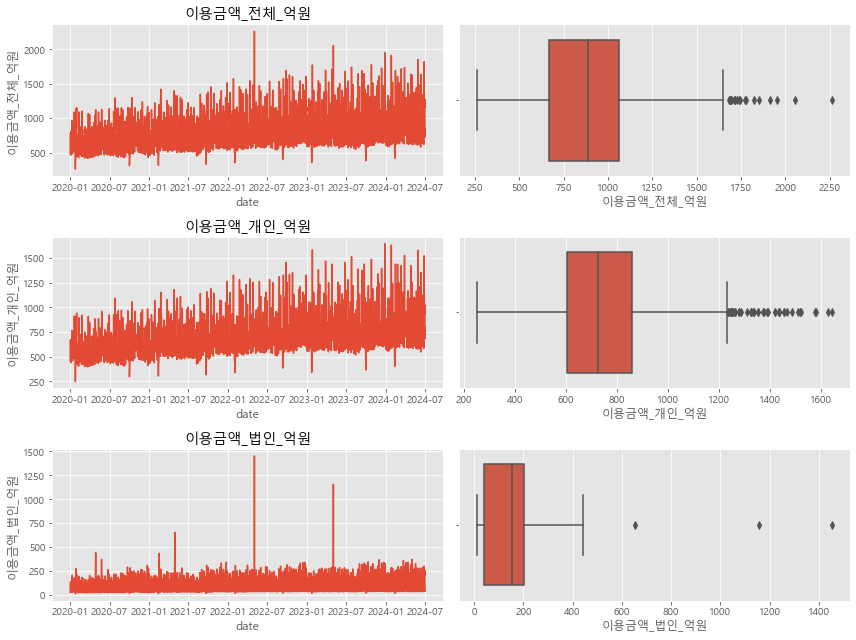

In [11]:
# 3-3. Outlier Detection
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,9))

variables = ['이용금액_전체_억원', '이용금액_개인_억원', '이용금액_법인_억원']
 
for i, vars in enumerate(variables):
    sns.lineplot(data=df, x='date', y=vars,
                ax=axes[i%3][0])
    sns.boxplot(data=df, x=vars,
                ax=axes[i%3][1])
    axes[i%3][0].set_title(vars)

    plt.tight_layout()

fig.suptitle('')
plt.show()

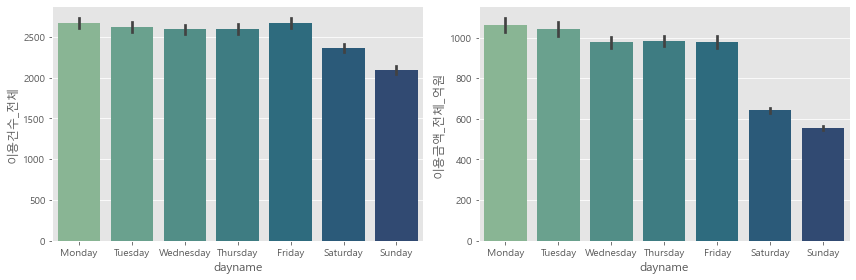

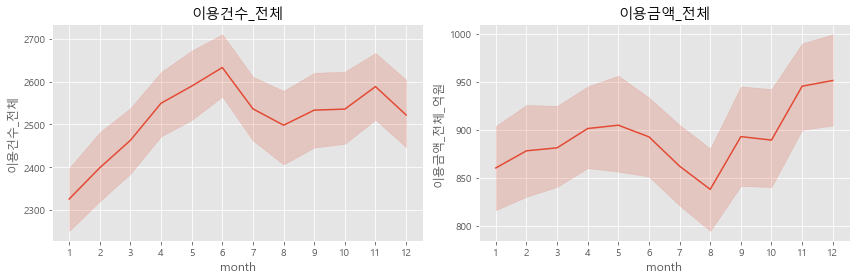

In [12]:
# 3-4. Sales by Day
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

sns.barplot(data=df, x='dayname', y='이용건수_전체', 
            palette='crest', ax=axes[0])
sns.barplot(data=df, x='dayname', y='이용금액_전체_억원', 
            palette='crest', ax=axes[1])
plt.tight_layout()
plt.show()

# 3-5. Sales by Month
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

sns.lineplot(data=df, x='month', y='이용건수_전체',
            palette='crest', ax=axes[0])
sns.lineplot(data=df, x='month', y='이용금액_전체_억원',
            palette='crest', ax=axes[1])

axes[0].set_title('이용건수_전체')
axes[1].set_title('이용금액_전체')
axes[0].set_xticks(range(1,13))
axes[1].set_xticks(range(1,13))

plt.tight_layout()
plt.show()

## 4. Regression Model Specification

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 4-1. Train-Validation Split
ind_vars = ['승인일자', 'year', 'month', 'day', 'dayofweek']
dep_vars = ['이용건수_개인', '이용건수_법인', '이용금액_개인_억원', '이용금액_법인_억원']

X = df[df['year'] != 2024][ind_vars]
y = df[df['year'] != 2024][dep_vars]

X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.2, 
                                                      random_state=42
                                                      )
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

# 4-2. Machine Learning (RandomForest, XGBoost, LightGBM)
dep_var = '이용금액_개인_억원'

model_rf = RandomForestRegressor(n_estimators=1000,
                                max_depth=20,
                                random_state=42)
model_rf.fit(X_train, y_train[dep_var])

model_xgb = XGBRegressor(random_state=42)
model_xgb.fit(X_train, y_train[dep_var]) 

model_lgbm = LGBMRegressor(random_state=42)
model_lgbm.fit(X_train, y_train[dep_var])


# 4-3. Model Comparison
from sklearn.metrics import mean_squared_error

y_sample = y_valid[dep_var]

y_pred_rf = model_rf.predict(X_valid)
mse_rf = mean_squared_error(y_pred_rf, y_sample)
print(f'MSE (RandomForest): {mse_rf:.2f}')

y_pred_xgb = model_xgb.predict(X_valid)
mse_xgb = mean_squared_error(y_pred_xgb, y_sample)
print(f'MSE (XGBoost): {mse_xgb:.2f}')

y_pred_lgbm = model_lgbm.predict(X_valid)
mse_lgbm = mean_squared_error(y_pred_lgbm, y_sample)
print(f'MSE (LightGBM): {mse_lgbm:.2f}')


# 4-4. Time Series Analysis (ARIMA)
# from statsmodels.tsa.arima_model import ARIMA
# model_arima = ARIMA()

print(f'''
      Q. Why not use ARIMA?
      A. Tried to use ARIMA model, but it was not suitable for the dataset
      ''')

# 4-5. Deep Learning Model (LSTM)
# import tensorflow as tf

print(f'''
      Q. Why not use LSTM or RNN?
      A. Couldn't use deep learning models due to the limited CPU, Memory, 
         and GPU resources in cloud environment.
      ''')

(1168, 5) (1168, 4)
(293, 5) (293, 4)


c:\Users\Red\miniconda3\envs\dl\lib\site-packages\joblib\externals\loky\backend\context.py:152: UserWarning: Could not find the number of physical cores for the following reason:
__init__() got an unexpected keyword argument 'capture_output'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  "following reason:\n" + str(exception) + "\n"
  File "c:\Users\Red\miniconda3\envs\dl\lib\site-packages\joblib\externals\loky\backend\context.py", line 229, in _count_physical_cores
    capture_output=True)
  File "c:\Users\Red\miniconda3\envs\dl\lib\subprocess.py", line 423, in run
    with Popen(*popenargs, **kwargs) as process:


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 312
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 5
[LightGBM] [Info] Start training from score 738.366739
MSE (RandomForest): 13813.88
MSE (XGBoost): 11969.03
MSE (LightGBM): 9832.48

      Q. Why not use ARIMA?
      A. Tried to use ARIMA model, but it was not suitable for the dataset
      

      Q. Why not use LSTM or RNN?
      A. Couldn't use deep learning models due to the limited CPU, Memory, 
         and GPU resources in cloud environment.
      


MSE (RandomForest): 8918.30
MSE (XGBoost): 4714.77
MSE (LightGBM): 7548.75


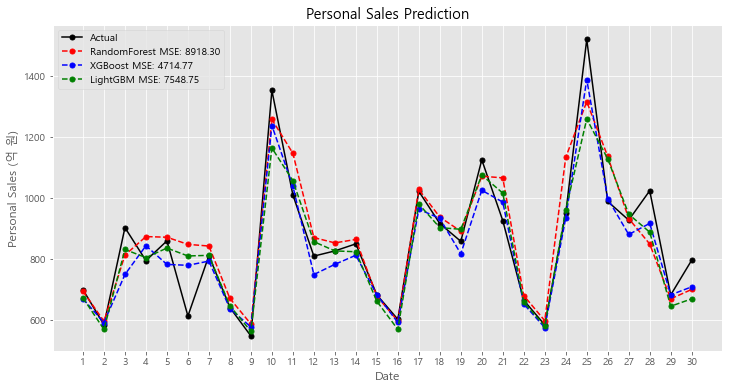

In [20]:
# %% 5. MODEL VALIDATION
# # 5-1. Model Tuning
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 500, 1000, 5000],
#     'max_depth': [1, 5, 10, 50, 100, 500, 1000]
# }

# # Initialize the model
# model_rf = RandomForestRegressor(random_state=42)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=model_rf, 
#                            param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', 
#                            n_jobs=4)

# # Fit the model
# grid_search.fit(X_train, y_train)

# # Get the best parameters and best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print(f'Best parameters: {best_params}')
# print(f'Best MSE: {best_score:.2f}')

# # Predict using the best model
# best_model = grid_search.best_estimator_
# y_pred_rf = best_model.predict(X_valid)
# mse_rf = mean_squared_error(y_pred_rf, y_valid)
# print(f'Validation MSE (RandomForest): {mse_rf:.2f}')

# y_pred_xgb = model_xgb.predict(X_valid)
# mse_xgb = mean_squared_error(y_pred_xgb, y_valid)
# print(f'Validation MSE (XGBoost): {mse_xgb:.2f}')

# y_pred_lgbm = model_lgbm.predict(X_valid)
# mse_lgbm = mean_squared_error(y_pred_lgbm, y_valid)
# print(f'Validation MSE (LightGBM): {mse_lgbm:.2f}')

# %% 5-2. Model Evaluation
test_period = df_test['date'].between('2024/06/01', '2024/06/30')

x_range = np.arange(1,len(df_test[test_period])+1)
X_test = df_test[test_period][ind_vars]
y_test = df_test[test_period][dep_var]

y_pred_rf = model_rf.predict(X_test)
y_pred_xgb = model_xgb.predict(X_test)
y_pred_lgbm = model_lgbm.predict(X_test)

mse_rf = mean_squared_error(y_pred_rf, y_test)
mse_xgb = mean_squared_error(y_pred_xgb, y_test)
mse_lgbm = mean_squared_error(y_pred_lgbm, y_test)

print(f'MSE (RandomForest): {mse_rf:.2f}')
print(f'MSE (XGBoost): {mse_xgb:.2f}')
print(f'MSE (LightGBM): {mse_lgbm:.2f}')

# %% 5-3. Model Visualization
plt.rc('figure', figsize=(12,6))

plt.plot(x_range, y_test, 
         marker='o', markersize=5, label='Actual', color='black')
plt.plot(x_range, y_pred_rf, 
         marker='o', markersize=5, label=f'RandomForest MSE: {mean_squared_error(y_pred_rf, y_test):.2f}', 
         linestyle='--', color='red')
plt.plot(x_range, y_pred_xgb,
            marker='o', markersize=5, label=f'XGBoost MSE: {mean_squared_error(y_pred_xgb, y_test):.2f}', 
            linestyle='--', color='blue')
plt.plot(x_range, y_pred_lgbm,
            marker='o', markersize=5, label=f'LightGBM MSE: {mean_squared_error(y_pred_lgbm, y_test):.2f}', 
            linestyle='--', color='green')

plt.title('Personal Sales Prediction')
plt.xlabel('Date')
plt.ylabel('Personal Sales (억 원)')
plt.xticks(x_range, df_test[test_period]['date'].dt.day)
plt.legend()
plt.show()

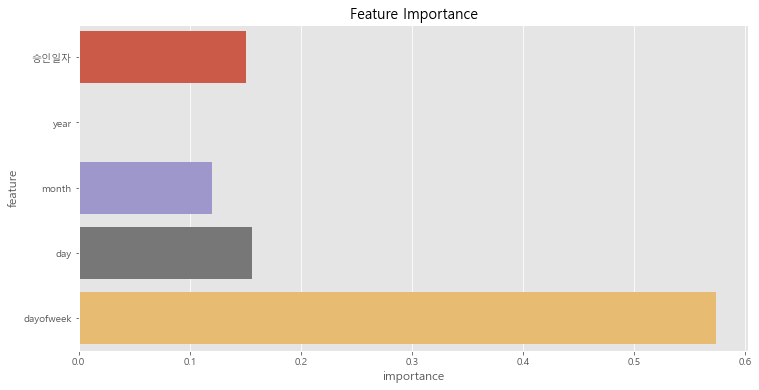

In [ ]:
# %% 5-4. Model Interpretation
best_model = model_xgb

# Feature Importance
feature_importance = best_model.feature_importances_
feature_names = X_train.columns

df_fi = pd.DataFrame({
    'feature': feature_names, 
    'importance': feature_importance
})

plt.figure(figsize=(12,6))

sns.barplot(data=df_fi, x='importance', y='feature')
plt.title('Feature Importance')
plt.show()
# %%

In [ ]:
print(f'numpy version: {np.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'seaborn version: {sns.__version__}')
print(f'matplotlib version: {mpl.__version__}')